In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import xarray as xr
import preprocess as pp
import util

import xskillscore as xs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
plot_varnames = ["tas", "pr", "psl"]

### Load interim data

In [ ]:
obs = xr.open_zarr("../data/interim/era5_timemean")

In [ ]:
ens_dict = {}
ens_av_dict = {}
ens_std_dict = {}
for key in pp.all_mip_ids:
    ens = xr.open_zarr(f"../data/interim/{key}_timemean").chunk({'lat': -1, 'lon':-1})
    ens_dict[key] = ens

### Quality control

In [ ]:
# Continental temperatures 20ºC higher than other ensemble members...
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'NIMS-KMA-KACE-1-0-G-r3i1p1f1')

# Units seem to be wrong... even after using the correction on the first ensemble member
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'UA-MCM-UA-1-0-r1i1p1f2')

## Mean absolute error

In [ ]:
area = util.calc_area(obs.lat, obs.lon)

mae_dict = {}
mae_av_dict = {}
mae_std_dict = {}
for key, ens in tqdm(ens_dict.items()):
    ens_av_tmp = ens.drop([var for var in list(ens.data_vars) if var not in plot_varnames])
    mae = xs.mae(obs.drop([var for var in list(obs.data_vars) if var not in list(ens_av_tmp.data_vars)]),
                           ens_av_tmp,
                           ['lat', 'lon'], weights=area).compute()
    mae_dict[key] = mae
    mae_av_dict[key] = mae.groupby('source_id').mean(skipna=True)
    mae_std_dict[key] = mae.groupby('source_id').std(skipna=True).copy()

In [ ]:
# TAR median
mae_med = mae_av_dict['cmip6'].sel(source_id=[key for key in mae_dict['cmip6'].source_id.values if key!='ens-mean']).median(dim='source_id', skipna=True).compute()

mae_skill_score_dict = {}
mae_std_skill_score_dict = {}
for key, mae in mae_av_dict.items():
    mae_skill_score_dict[key] = (mae/mae_med)
    mae_std_skill_score_dict[key] = (mae_std_dict[key]/mae_med)

# Skill metrics over time

In [ ]:
mip_year_dict = {'far': 1990,
                 'sar': 1996,
                 'tar': 2000,
                 'cmip3': 2005,
                 'cmip5': 2013,
                 'cmip6': 2019}

mip_col = {'far': 'C5',
           'sar': 'C4',
           'tar': 'C3',
           'cmip3': 'C2',
           'cmip5': 'C1',
           'cmip6': 'C0'}

var_shape = {'tas': 'o', 'pr': 's', 'psl': 'D'}

In [ ]:
fig, axes = plt.subplots(len(plot_varnames),1,figsize=(8,12))

ax=axes[0]
ens_mean_label = "ens-mean"
ax.plot([], [], 'k<', markersize=10, label=ens_mean_label)
ax.plot([], [], 'k>', markersize=10, label='ens-median')

ax.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['psl'], markersize=10, label='sfcWind', linewidth=0.)

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(var_shape.keys()):
        
        if var_key not in mae_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        ax = axes[idx]
        
        data = mae_skill_score_dict[key][var_key]
        data_err = mae_std_skill_score_dict[key][var_key]
        ax.errorbar(
            data,
            mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
            xerr=data_err,
            linewidth=0., elinewidth=1., ecolor='k',
            marker=var_shape[var_key], markersize=10, alpha=0.5, label=ens_label, color=mip_col[key]
        )
#         ax.plot(data,mip_year_dict[key]*np.ones_like(data),
#                  var_shape[var_key], markersize=10, alpha=0.5, label=ens_label, color=mip_col[key])
    

#         data = mae_skill_score_dict[key][var_key].median(skipna=True)
#         ax.plot(data, mip_year_dict[key]*np.ones_like(data),
#              marker='>', markersize=20, color=mip_col[key], markeredgecolor='k')
        
        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']
var_minlim = [0.0, 0.0, 0.0]
var_maxlim = [2.5, 2.5, 2.5]
for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([var_minlim[subplot_count], var_maxlim[subplot_count]])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    if subplot_count == 0: ax.legend()
    ax.set_title(var_longname[subplot_count]+' performance')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_scatter.png",bbox_inches='tight',dpi=100)

In [ ]:
fig, axes = plt.subplots(len(plot_varnames),1,figsize=(8,12))

ax=axes[0]
ens_mean_label = "ens-mean"
ax.plot([], [], 'k<', markersize=10, label=ens_mean_label)
ax.plot([], [], 'k>', markersize=10, label='ens-median')

ax.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['psl'], markersize=10, label='sfcWind', linewidth=0.)

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(var_shape.keys()):
        
        if var_key not in mae_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        ax = axes[idx]
        
        data = mae_skill_score_dict[key][var_key]
        data = data[~np.isnan(data)]
        
        alpha=0.75
        markersize=15.
        if data.size > 10:
            alpha=0.4
            markersize=10
            
        ax.plot(
            data,mip_year_dict[key]*np.ones_like(data),
            linewidth=0, marker=".", markersize=markersize, alpha=alpha, color="C0"
        )
        
        if data.size > 10:
            parts = ax.violinplot(
                data[~np.isnan(data)],
                positions=[mip_year_dict[key]],
                widths = 5.,
                vert=False, showextrema=False,
            )

            for pc in parts['bodies']:
                pc.set_facecolor("C0")
                pc.set_edgecolor("k")
                pc.set_alpha(0.3)

        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']
var_minlim = [0.0, 0.0, 0.0]
var_maxlim = [3.5, 3.5, 3.5]
for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([var_minlim[subplot_count], var_maxlim[subplot_count]])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    if subplot_count == 0: ax.legend()
    ax.set_title(var_longname[subplot_count]+' performance')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_violin.png",bbox_inches='tight',dpi=100)

In [77]:
mip = 'sar'
percent_spread = (mae_dict[mip].groupby('source_id').max() - mae_dict[mip].groupby('source_id').min())/mae_dict[mip].groupby('source_id').mean(skipna=True)

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


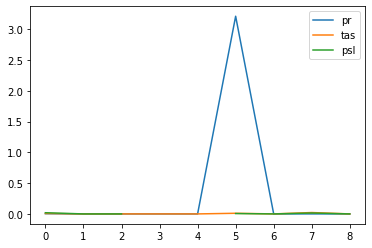

In [78]:
plt.plot(percent_spread['pr'].values, label='pr')
plt.plot(percent_spread['tas'].values, label='tas')
plt.plot(percent_spread['psl'].values, label='psl')
plt.legend()

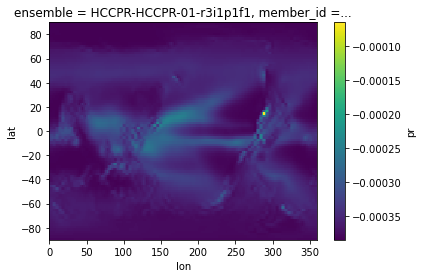

In [79]:
ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr'].plot()

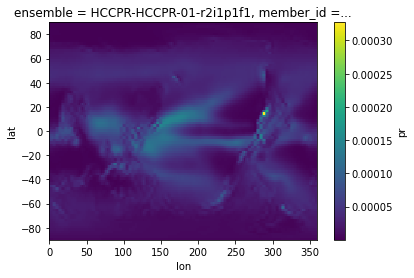

In [67]:
ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr'].plot()

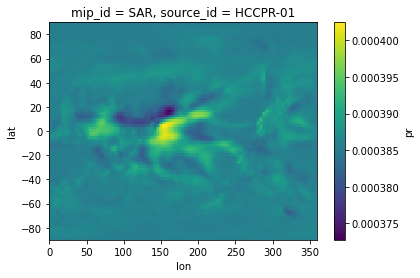

In [65]:
(ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr'] - ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr']).plot()